In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh
%cd ..

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 6.91 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 kB 37.3 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-07-10 05:18:48--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.135, 13.200.41.136, 13.200.41.134, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.135|:443... connected.
HTTP request sent, awai

In [2]:
from konlpy.tag import Mecab

mecab = Mecab()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력


전체 리뷰 개수 : 100000


In [4]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [5]:
total_data['reviews'].nunique(), total_data['label'].nunique()


(99892, 2)

In [6]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))


총 샘플의 수 : 99892


In [7]:
print(total_data.isnull().values.any())


False


In [8]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))


훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


<Axes: xlabel='label'>

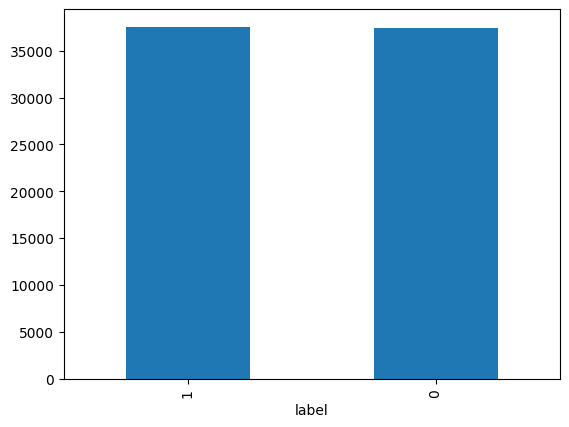

In [9]:
train_data['label'].value_counts().plot(kind = 'bar')


In [10]:
print(train_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0  37376
1      1  37543


In [11]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data['reviews'] = train_data['reviews'].replace('', np.nan)
print(train_data.isnull().sum())


label      0
reviews    0
dtype: int64


In [12]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['reviews'] = test_data['reviews'].replace('', np.nan) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 24973


In [13]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']


In [14]:
mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [15]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)


In [16]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))


[(np.str_('안'), 8125), (np.str_('없'), 7141), (np.str_('는데'), 5729), (np.str_('있'), 5690), (np.str_('같'), 4251), (np.str_('로'), 4171), (np.str_('할'), 3931), (np.str_('거'), 3903), (np.str_('나'), 3818), (np.str_('해'), 3650), (np.str_('너무'), 3521), (np.str_('으로'), 3351), (np.str_('기'), 3350), (np.str_('했'), 3262), (np.str_('어'), 3155), (np.str_('습니다'), 2962), (np.str_('지만'), 2951), (np.str_('것'), 2937), (np.str_('겠'), 2901), (np.str_('않'), 2898)]


긍정 리뷰의 평균 길이 : 14.947979650001331
부정 리뷰의 평균 길이 : 15.284701412671232


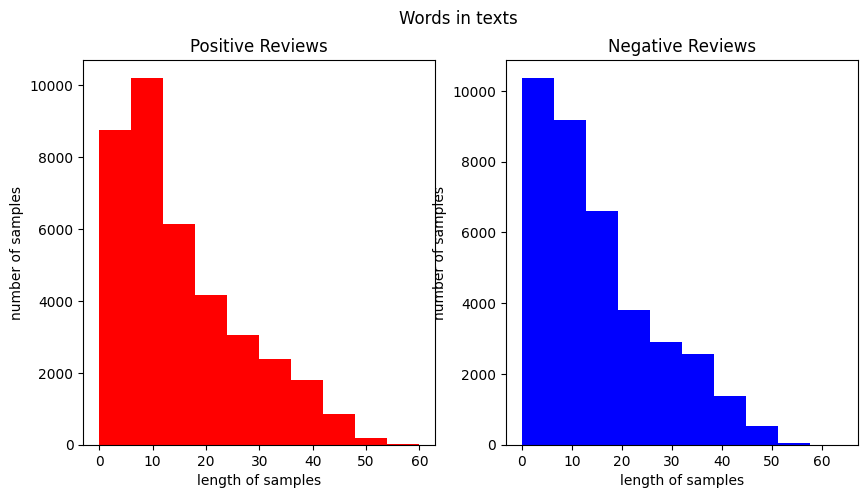

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()


In [18]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values


In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


In [20]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 32920
등장 빈도가 1번 이하인 희귀 단어의 수: 13905
단어 집합에서 희귀 단어의 비율: 42.23876063183475
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.227843842634659


In [21]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 19017


In [22]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [23]:
print(X_train[:3])
print(X_test[:3])


[[469, 635, 7, 35, 86, 149, 2417, 600, 26, 8, 70, 47, 233, 110, 38, 43, 52], [160, 300, 18, 21, 63, 3577, 985, 6, 56], [7, 16, 1477, 4]]
[[729, 34, 15, 433, 52, 106, 132, 88, 6459, 457], [4518, 689, 832, 713, 687, 109, 4, 1782, 98, 371, 3516, 81, 559, 1903, 4309, 261, 168, 61, 25, 364, 35, 86, 977, 19, 6292, 6417], [1728, 793, 567, 49, 23, 349]]


리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.11596524246186


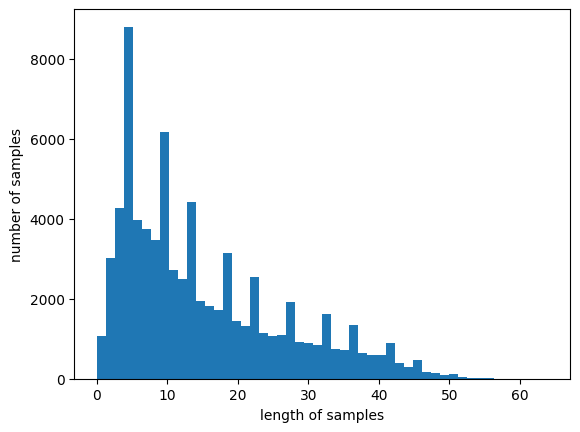

In [24]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [25]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [26]:
max_len = 60
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99733045021956


In [27]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


In [28]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('20250710_강의복습_BiLSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)


Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - acc: 0.5985 - loss: 0.6561
Epoch 1: val_acc improved from -inf to 0.72290, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 115s 473ms/step - acc: 0.5988 - loss: 0.6559 - val_acc: 0.7229 - val_loss: 0.5357
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - acc: 0.7685 - loss: 0.4866
Epoch 2: val_acc improved from 0.72290 to 0.76822, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 143s 477ms/step - acc: 0.7685 - loss: 0.4866 - val_acc: 0.7682 - val_loss: 0.4889
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - acc: 0.8008 - loss: 0.4431
Epoch 3: val_acc improved from 0.76822 to 0.78043, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 140s 467ms/step - acc: 0.8008 - loss: 0.4431 - val_acc: 0.7804 - val_loss: 0.4678
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - acc: 0.8128 - loss: 0.4198
Epoch 4: val_acc improved from 0.78043 to 0.78177, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 109s 464ms/step - acc: 0.8128 - loss: 0.4199 - val_acc: 0.7818 - val_loss: 0.4674
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - acc: 0.8247 - loss: 0.4048
Epoch 5: val_acc improved from 0.78177 to 0.78257, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 108s 461ms/step - acc: 0.8247 - loss: 0.4048 - val_acc: 0.7826 - val_loss: 0.4687
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - acc: 0.8316 - loss: 0.3880
Epoch 6: val_acc did not improve from 0.78257
235/235 ━━━━━━━━━━━━━━━━━━━━ 146s 478ms/step - acc: 0.8315 - loss: 0.3880 - val_acc: 0.7801 - val_loss: 0.4884
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - acc: 0.8419 - loss: 0.3693
Epoch 7: val_acc did not improve from 0.78257
235/235 ━━━━━━━━━━━━━━━━━━━━ 143s 483ms/step - acc: 0.8419 - loss: 0.3694 - val_acc: 0.7754 - val_loss: 0.4890
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - acc: 0.8508 - loss: 0.3544
Epoch 8: val_acc did not improve from 0.78257
235/235 ━━━━━━━━━━━━━━━━━━━━ 109s 465ms/step - acc: 0.8508 - loss: 0.3544 - val_acc: 0.7756 - val_loss: 0.5001
Epoch 8: early stopping


In [31]:
model.save('20250710_강의복습_BiLSTM.keras')

In [34]:
loaded_model = load_model('20250710_강의복습_BiLSTM.keras')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - acc: 0.7668 - loss: 0.5075
테스트 정확도: 0.7724


In [35]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [36]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
92.85% 확률로 부정 리뷰입니다.


/tmp/ipython-input-35-3027652201.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [37]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
98.13% 확률로 긍정 리뷰입니다.


/tmp/ipython-input-35-3027652201.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [38]:
sentiment_predict('케릭터가 예뻐서 좋아요')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
78.94% 확률로 긍정 리뷰입니다.


/tmp/ipython-input-35-3027652201.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측
